In [1]:
import numpy as np # linear algebra

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import re
# import matplotlib as mpl
# from wordcloud import WordCloud, STOPWORDS
sns.set()
%matplotlib inline
import pandas as pd

# import random
# import plotly
# from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
import plotly.offline as offline
import plotly.graph_objs as go

# Model
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate
from sklearn.metrics import log_loss
from scipy.optimize import minimize
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import KFold
from sklearn import model_selection, preprocessing

import warnings
warnings.filterwarnings('ignore')

In [2]:
from consigli.config import data_path_source
from consigli.modules.data_prep_processing import read_data
from loguru import logger

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Current memory usage: 815.693102
Peak memory usage: 1649.893460


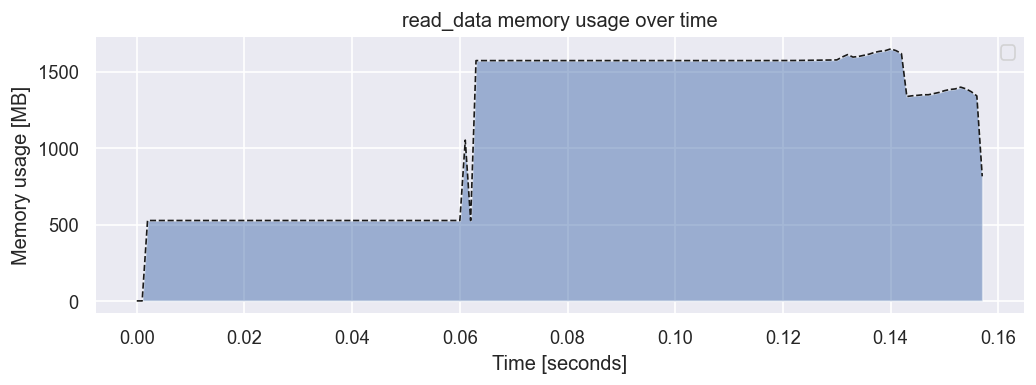

In [3]:
data_path = data_path_source
df, mem_history_1 = read_data(data_path)

In [4]:
from consigli.modules.data_prep_processing import dask_read

# executing
# df_dd = dask_read(data_path, blocksize=90e6)

## EDA
Catch the glimpse of the data


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 478064 entries, 0 to 478063
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   file_name  478064 non-null  object
 1   pagenum    478064 non-null  int64 
 2   content    478064 non-null  object
 3   el_number  478064 non-null  int64 
 4   category   478064 non-null  object
dtypes: int64(2), object(3)
memory usage: 18.2+ MB


In [6]:
#df.category.str.replace(' ', '')
# df['category'].astype(str).str.split()
df['category'] = df['category'].astype('string').replace('\x00', '').str.replace(' ', '').astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 478064 entries, 0 to 478063
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   file_name  478064 non-null  object
 1   pagenum    478064 non-null  int64 
 2   content    478064 non-null  object
 3   el_number  478064 non-null  int64 
 4   category   478064 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 18.2+ MB


In [7]:
logger.info("The training data consists of {} recipes".format(len(df)))
logger.info("The shape of the data is {}".format(df.shape))

2022-12-08 13:35:13.409 | INFO     | __main__:<module>:1 - The training data consists of 478064 recipes
2022-12-08 13:35:13.410 | INFO     | __main__:<module>:2 - The shape of the data is (478064, 5)


In [8]:
print("First five elements in our training sample:")
df.head(5)

First five elements in our training sample:


,file_name,pagenum,content,el_number,category
0,00206BA4E8F5200610123622.pdf,0,K3G800-PW07-01 EC centrifugal module...,0,36
1,00206BA4E8F5200610123622.pdf,0,"backward-curved, single-intake\n ...",1,36
2,00206BA4E8F5200610123622.pdf,0,ebm-papst Mulfingen GmbH & Co. KG\n ...,2,36
3,00206BA4E8F5200610123622.pdf,0,Nominal data,3,36
4,00206BA4E8F5200610123622.pdf,0,Type K3G800-PW07-01\n Motor M3G200-QA,4,36


In [9]:
print("Number of document categories: {}".format(len(df.category.unique())))
df.category.unique()

Number of document categories: 63


array([ 36,  20,  43,  77,  67,  15,  47,  40,  12,  24,  13,  14,  11,
        52,  54,  32,  25,  41,  31,  26,  33,  19,  62,  10,  22,  23,
        27,  57,  28,  29,  35,  56,  37,  44,  45,  46,  51,  53,  55,
        61,  65, 620,  34, 546, 556, 542, 552,  21,  76,  18, 547,  58,
        71, 548, 102,  16,  42,  49,  66,  30, 233, 210,  74])

In [10]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
pagenum,478064.0,30.427589,76.728164,0.0,1.0,5.0,25.0,1253.0
el_number,478064.0,187.458211,351.748782,0.0,15.0,49.0,185.0,3079.0
category,478064.0,48.429702,83.451258,10.0,20.0,36.0,53.0,620.0


In [11]:
import random

#Define a function to generate randoms colors for further visualizations
def random_colours(number_of_colors):
    colors = []
    for i in range(number_of_colors):
        colors.append("#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]))
    return colors

### Explore the document categories (the target)

In [12]:
trace = go.Table(
                header=dict(values=['Category','Number of documents'],
                fill = dict(color=['#EABEB0']),
                align = ['left'] * 5),
                cells=dict(values=[df.category.value_counts().index,df.category.value_counts()],
                align = ['left'] * 5))

layout = go.Layout(title='Number of categories in each document category',
                   titlefont = dict(size = 20),
                   width=500, height=650,
                   paper_bgcolor =  'rgba(0,0,0,0)',
                   plot_bgcolor = 'rgba(0,0,0,0)',
                   autosize = False,
                   margin=dict(l=30,r=30,b=1,t=50,pad=1),
                   )
data = [trace]
fig = dict(data=data, layout=layout)
iplot(fig)

In [13]:
#  Label distribution in percents
labelpercents = []
for i in df.category.value_counts():
    percent = (i/sum(df.category.value_counts()))*100
    percent = "%.2f" % percent
    percent = str(percent + '%')
    labelpercents.append(percent)

In [14]:
trace = go.Bar(
            x=df.category.value_counts().values[::-1],
            y= [i for i in df.category.value_counts().index][::-1],
            text =labelpercents[::-1],  textposition = 'outside',
            orientation = 'h',marker = dict(color = random_colours(20)))
layout = go.Layout(title='Number of documents in each document category',
                   titlefont = dict(size = 25),
                   width=1030, height=450,
                   plot_bgcolor = 'rgba(0,0,0,0)',

                   margin=dict(l=75,r=110,b=50,t=60),
                   )
data = [trace]
fig = dict(data=data, layout=layout)
iplot(fig, filename='horizontal-bar')

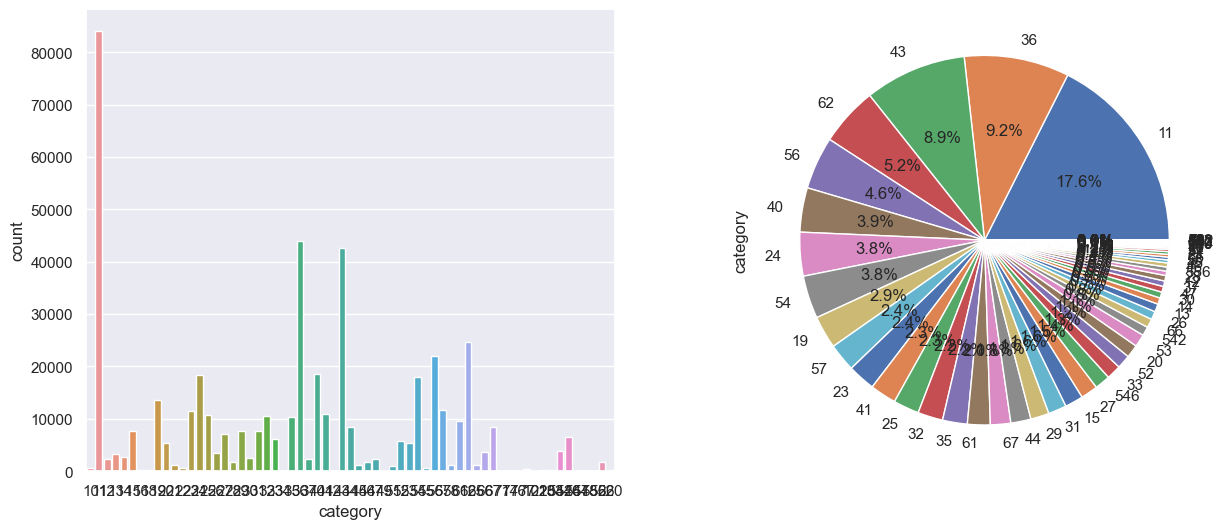

In [15]:
fig, ax=plt.subplots(1,2,figsize=(15,6))
_ = sns.countplot(x='category', data=df, ax=ax[0])
_ = df['category'].value_counts().plot.pie(autopct="%1.1f%%", ax=ax[1])

### Task 1: Text search

In [16]:
logger.info('Task 1: Text search. \n')

2022-12-08 13:35:38.431 | INFO     | __main__:<module>:1 - Task 1: Text search. 



In [17]:
from consigli.text_search import get_list_content, text_search

def text_search_(url, keyword_one, keyword_two):

    df, mem_history_1 = read_data(url)
    contents = get_list_content(df)
    text_search(contents=contents, words=[keyword_one, keyword_two])

    logger.info('Done.!')


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Current memory usage: 1631.726622
Peak memory usage: 2466.017246


2022-12-08 13:37:06.614 | INFO     | consigli.text_search:text_search:54 - Total number of sentences that discuss vedlikehold and halvårlig are: 8 

2022-12-08 13:37:06.614 | INFO     | consigli.text_search:text_search:57 - 1:• Etter lang tids stillstand. Det anbefales å gjennomføre vedlikehold før idriftsetting. Tøm vannreservoarene til ekspansjonsautomaten (illustrasjon 62; 66) og se til at ettersyn av alle gjeldende, nødvendige betingelser for montering og idriftsetting gjøres på nytt. Bruk protokollen for idriftsetting også når det er snakk om en gjentatt aktivering av anlegget og kontroller spesielt for anleggsendringer som kan føre til andre driftsforhold for ekspansjonsautomaten (for eksempel innstilt trykk). • Etter strømavbrudd. Programmerte verdier og innstillinger i styresystemet for opprettholdelse av trykk, avlufting og etterfylling blir værende, slik at driften automatisk tas opp igjen når driftsspenningen kommer tilbake (Styresystem PÅ). Spesielle driftsforhold i anlegge

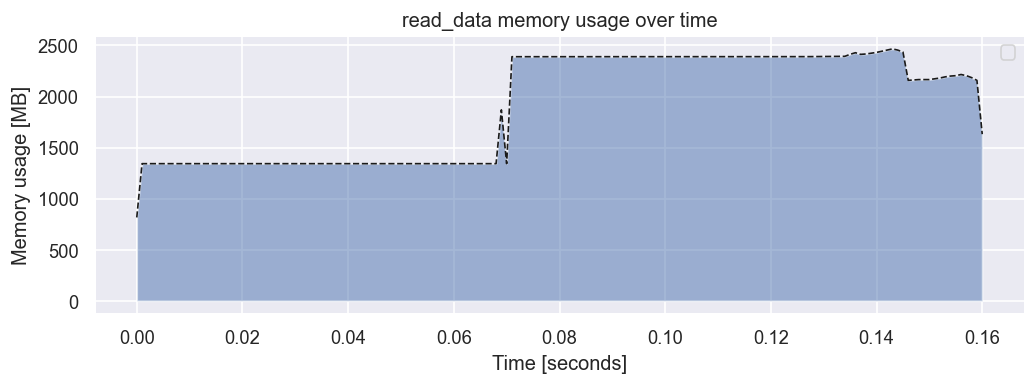

In [18]:
text_search_(url=data_path, keyword_one='vedlikehold', keyword_two='halvårlig')

In [19]:
logger.info('Task 1: Document Classification. \n')

2022-12-08 13:37:25.032 | INFO     | __main__:<module>:1 - Task 1: Document Classification. 



### Data preprocessing

In [20]:
df.isnull().sum()

file_name    0
pagenum      0
content      0
el_number    0
category     0
dtype: int64

The document contents are processed in the following aspects:
1. Case Normalization - convert all to lower case
2. Remove punctuation, digits or special characters
3. Remove different units

In [22]:
from consigli.modules.data_prep_processing import replace_newlines, lowercase, remove_after_apostrophe, remove_numbers, \
    remove_extra_space, remove_repeated_chars, remove_single_char_word, replace_emojis, replace_url, replace_email, \
    apply_preprocessing

# Prepare the data
# features = [] # list of list containing the documents
# [features.append(item) for item in df['content']]

features_processed= [] # here we will store the preprocessed features
df_preprocess =  df.head(5000)

df_preprocess["content_processed"] = df_preprocess.apply(lambda row: apply_preprocessing(row['content']), axis = 1)
df_preprocess.head(5)

,file_name,pagenum,content,el_number,category,content_processed
0,00206BA4E8F5200610123622.pdf,0,K3G800-PW07-01 EC centrifugal module...,0,36,pw ec centrifugal module radipac
1,00206BA4E8F5200610123622.pdf,0,"backward-curved, single-intake\n ...",1,36,backward curved single intake with cube design
2,00206BA4E8F5200610123622.pdf,0,ebm-papst Mulfingen GmbH & Co. KG\n ...,2,36,ebm papst mulfingen gmbh co kg bachmihle mulfi...
3,00206BA4E8F5200610123622.pdf,0,Nominal data,3,36,nominal data
4,00206BA4E8F5200610123622.pdf,0,Type K3G800-PW07-01\n Motor M3G200-QA,4,36,type pw motor qa


In [23]:
logger.info("The training score for random forest: {}".format(len(df_preprocess)))

2022-12-08 13:37:46.080 | INFO     | __main__:<module>:1 - The training score for random forest: 5000


In [24]:
# df_preprocess = df_preprocess.copy()                          # Create duplicate of data
df_preprocess.dropna(inplace = True)                      # Remove rows with NaN

df_preprocess = df_preprocess[df_preprocess['content_processed'] != '']
df_preprocess = df_preprocess[df_preprocess['content_processed'] != ' ']

df_preprocess = df_preprocess[pd.notnull(df_preprocess.content_processed)]
logger.info("The training score for random forest: {}".format(len(df_preprocess)))

2022-12-08 13:37:47.003 | INFO     | __main__:<module>:8 - The training score for random forest: 4760


In [25]:
# Prepare the data
features_processed = [] # list of list containing the recipes
for item in df_preprocess['content_processed']:
    features_processed.append(item)

In [26]:
# Check for empty instances in train samples after processing before proceeding to next stage of the analysis
def check_empty_isinstance(list_):
    count_m = []
    for content in list_:
        if not content:
            count_m.append([content])
        else: pass
    print("Empty instances in the preprocessed sample: " + str(len(count_m)))

check_empty_isinstance(list_=features_processed)

Empty instances in the preprocessed sample: 0


In [27]:
# Remove the empty features
# features_processed = list(filter(None, features_processed))
# check_empty_isinstance(list_=features_processed)

In [28]:
logger.info("The data  consists of {} documents".format(len(features_processed)))

2022-12-08 13:37:53.935 | INFO     | __main__:<module>:1 - The data  consists of 4760 documents


In [29]:
# features_processed
# logger.info("The documents are: {} ".format(features_processed))

### Feature Engineering

In [30]:
vectorizer = TfidfVectorizer(min_df=3,  max_features=None, 
           strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 3), use_idf=1,smooth_idf=1,sublinear_tf=1, stop_words = 'english')
X = vectorizer.fit_transform(features_processed)

In [31]:
# Binary representation of the training set will be employed
'''
vectorizer = CountVectorizer(analyzer = "word",
                             ngram_range = (1,1), # unigrams
                             binary = True, #  (the default is counts)
                             tokenizer = None,
                             preprocessor = None,
                             stop_words = None,
                             max_df = 0.99) # any word appearing in more than 99% of the sample will be discarded
'''
                             # Fit the vectorizer on the training data and transform the test sample
# X = vectorizer.fit_transform([str(i) for i in features_processed])


'\nvectorizer = CountVectorizer(analyzer = "word",\n                             ngram_range = (1,1), # unigrams\n                             binary = True, #  (the default is counts)\n                             tokenizer = None,\n                             preprocessor = None,\n                             stop_words = None,\n                             max_df = 0.99) # any word appearing in more than 99% of the sample will be discarded\n'

### Model development

In [33]:
# Extract the target variable
target = df_preprocess['category']
logger.info("The data consists of {} documents with {} labels".format(len(features_processed), len(target)))

2022-12-08 13:38:26.146 | INFO     | __main__:<module>:3 - The data consists of 4760 documents with 4760 labels


In [34]:
target

0       36
1       36
2       36
3       36
4       36
        ..
4995    11
4996    11
4997    11
4998    11
4999    11
Name: category, Length: 4760, dtype: int64

In [35]:
# Apply label encoding on the target variable (before model development)
lb = LabelEncoder()
Y = lb.fit_transform(target)

In [36]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state = 42)

In [40]:
# Scale the data obtained from SVD. Renaming variable to reuse without scaling.
# scl = preprocessing.StandardScaler()
# scl.fit(X_train)
# X_train = scl.transform(X_train)
# X_test = scl.transform(X_test)

array([1, 1, 6, ..., 6, 3, 9])

In [38]:
def draw_confusion_matrix(cm):
    plt.figure(figsize=(12,8))
    sns.heatmap(cm,annot=True,fmt="d", center=0, cmap='autumn')
    plt.title("Confusion Matrix")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [39]:
### building the classifiers
clfs = []

In [ ]:
from sklearn.metrics import accuracy_score

logreg = LogisticRegression(random_state=42)
logreg.fit(X_train, y_train)

y_predict_train_logreg = logreg.predict(X_train)
y_predict_test_logreg = logreg.predict(X_test)

train_accuracy_score_logreg = accuracy_score(y_train, y_predict_train_logreg)
test_accuracy_score_logreg = accuracy_score(y_test, y_predict_test_logreg)

logger.info("The training score for log. reg: {}".format(train_accuracy_score_logreg))
logger.info("The test score for log. reg: {}".format(test_accuracy_score_logreg))
clfs.append(logreg)

In [ ]:
rf = RandomForestClassifier(random_state=42, n_estimators=50, max_depth=6, criterion = 'entropy',
                            min_samples_leaf= 1, min_samples_split= 2)
rf.fit(X_train, y_train)

y_predict_train_rf = rf.predict(X_train)
y_predict_test_rf = rf.predict(X_test)

train_accuracy_score_rf = accuracy_score(y_train, y_predict_train_rf)
test_accuracy_score_rf = accuracy_score(y_test, y_predict_test_rf)

logger.info("The training score for random forest: {}".format(train_accuracy_score_rf))
logger.info("The test score for random forest: {}".format(test_accuracy_score_rf))
clfs.append(rf)

In [ ]:
svc = SVC(random_state=42,probability=True, kernel='linear')
svc.fit(X_train, y_train)

y_predict_train_rf = svc.predict(X_train)
y_predict_test_rf = svc.predict(X_test)

train_accuracy_score_svc = accuracy_score(y_train, y_predict_train_rf)
test_accuracy_score_svc = accuracy_score(y_test, y_predict_test_rf)

# print(train_accuracy_score_svc)
# print(test_accuracy_score_svc)

logger.info("The training score for svc: {}".format(train_accuracy_score_svc))
logger.info("The test score for svc : {}".format(test_accuracy_score_svc))
clfs.append(svc)

In [ ]:
from sklearn.metrics import confusion_matrix

cm_rf = confusion_matrix(y_test, y_predict_test_rf)
draw_confusion_matrix(cm_rf)

#### Define a function to find the optimum weights of ensemble model based on log loss.
Logarithmic loss measures the performance of a classification model where the prediction input is a probability value between 0 and 1. The goal of our machine learning models is to minimize this value.

Accuracy is the count of predictions where your predicted value equals the actual value. Accuracy is not always a good indicator because of its yes or no nature. Log Loss takes into account the uncertainty of your prediction based on how much it varies from the actual label. This gives us a more nuanced view into the performance of our model.

In [ ]:
## finding the optimum weights

predictions = []
for clf in clfs:
    predictions.append(clf.predict_proba(X_test))

def log_loss_func(weights):
    ''' scipy minimize will pass the weights as a numpy array '''
    final_prediction = 0
    for weight, prediction in zip(weights, predictions):
            final_prediction += weight*prediction

    return log_loss(y_test, final_prediction)

#the algorithms need a starting value, right not we chose 0.5 for all weights
starting_values = [0.5]*len(predictions)

cons = ({'type':'eq','fun':lambda w: 1-sum(w)})
#our weights are bound between 0 and 1
bounds = [(0,1)]*len(predictions)

res = minimize(log_loss_func, starting_values, method='SLSQP', bounds=bounds, constraints=cons)

logger.info('Ensamble Score: {best_score}'.format(best_score=res['fun']))
logger.info('Best Weights: {weights}'.format(weights=res['x']))

In [ ]:
# Ensemble Unigram model (baseline model)
vclf=VotingClassifier(estimators=[('clf1',RandomForestClassifier(n_estimators = 50,random_state = 42)),
                                  ('clf2',LogisticRegression(random_state = 42)),
                                  ('clf3',SVC(kernel='linear',random_state = 42,probability=True))
                                  ],
                                    voting='soft', weights = [0.05607363, 0.70759724, 0.23632913])
vclf.fit(X_train, y_train)

In [ ]:
# 5-fold Cross validation of  the results
kfold = model_selection.KFold(n_splits=5)
valscores = model_selection.cross_val_score(vclf, X_train, y_train, cv=kfold)
logger.info('Mean accuracy on 5-fold cross validation: ' + str(np.mean(valscores)))

### Deep Learning¶
 Here, we will train LSTM and a simple dense network. Let's start with the dense network first:

In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.svm import SVC
from keras.models import Sequential
from keras.layers import LSTM, GRU
from keras.layers.core import Dense, Activation, Dropout
from keras.layers import Embedding
from keras.layers import BatchNormalization
from keras.utils import np_utils
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
from keras.preprocessing import text
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping

from nltk import word_tokenize

In [ ]:
xtrain, xtest, ytrain, ytest = train_test_split(df_preprocess.content.values, target,  
                                                  random_state=42, 
                                                  test_size=0.1, shuffle=True)

# we need to binarize the labels for the neural net
# ytrain_enc = np_utils.to_categorical(ytrain)

# using keras tokenizer here
token = text.Tokenizer(num_words=None)
max_len = 10

xtrain_seq = token.texts_to_sequences(xtrain)
xtest_seq = token.texts_to_sequences(xtest)

# zero pad the sequences
xtrain_pad = pad_sequences(xtrain_seq, maxlen=max_len)

xtest_pad = pad_sequences(xtest_seq, maxlen=max_len)

word_index = token.word_index

In [ ]:
# create an embedding matrix for the words we have in the dataset
embedding_matrix = np.zeros((len(word_index) + 1, 300))
for word, i in tqdm(word_index.items()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [ ]:
# A simple LSTM with glove embeddings and two dense layers
model = Sequential()
model.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))
model.add(SpatialDropout1D(0.3))
model.add(LSTM(100, dropout=0.3, recurrent_dropout=0.3))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(1))
model.add(Activation('softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam')

In [ ]:
model.fit(xtrain_pad, y=ytrain, batch_size=512, epochs=100, verbose=1, validation_data=(xtest_pad, ytest))

In [ ]:
target